In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment

from pathlib import Path
import json
import yaml

2023-04-03 17:51:13.362184: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import procgen

In [3]:
from IPython.display import clear_output

In [4]:
import gym
env = gym.make('procgen-coinrun-v0')

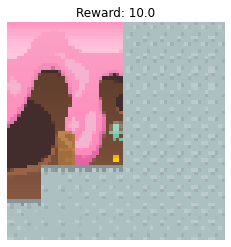

In [5]:
obs = env.reset()

def render(obs, reward=None, clear=True):
    plt.imshow(obs)
    if reward is not None:
        plt.title(f"Reward: {reward}")
    plt.axis('off')
    plt.show()
    if clear:
        clear_output(wait=True)

reward = 0
try:
    while True:
        obs, reward, done, info = env.step(env.action_space.sample())
        render(obs, reward)
        if done:
            break

except KeyboardInterrupt:
    render(obs, reward)

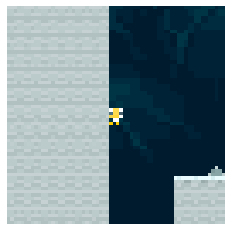

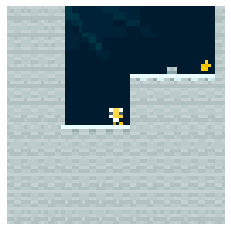

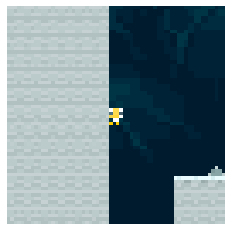

In [6]:
obs = env.reset()

for _ in range(10):
    obs, *_ = env.step(env.action_space.sample())

render(obs, clear=False)
state = env.env.env.get_state()

for _ in range(100):
    obs, *_ = env.step(env.action_space.sample())

render(obs, clear=False)
env.env.env.set_state(state)

render(env.env.observe()[1][0])


In [7]:
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.policies import TFPolicy
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.policies.random_py_policy import RandomPyPolicy
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [8]:
gym_env = GymWrapper(env)
gym_env._action_is_discrete = False  # gym wrapper takes action from numpy array unless this is set

tf_env = TFPyEnvironment(gym_env)
tf_env.reset()

random_policy = RandomTFPolicy(
    tf_env.time_step_spec(),
    tf_env.action_spec()
)

2023-04-03 17:51:37.397557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 17:51:37.409471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 17:51:37.409820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 17:51:37.410925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

In [9]:
tf_env.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [10]:
random_policy.action(tf_env.current_time_step())

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([11])>, state=(), info=())

In [11]:
from mlrl.utils import render_utils

In [12]:
import cv2

def render_fn(tf_env, *_):
    cenv = tf_env._env.envs[0].env.env
    img = cenv.observe()[1]['rgb'][0]
    img = cv2.resize(img, (4*img.shape[0], 4*img.shape[1]),
                     interpolation=cv2.INTER_NEAREST)
    return img

In [13]:
render_utils.embed_mp4(render_utils.save_policy_eval_video(
    random_policy, tf_env, render_fn, 'video', max_steps=15*30), width=256, height=256)

In [14]:
class Autoencoder(tf.keras.Model):

    def __init__(self, enc_dim=64):
        super(Autoencoder, self).__init__()
        
        self.encoding_dim = enc_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), 
                                   activation='relu', 
                                   input_shape=(64, 64, 3)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(enc_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(units=8*8*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=2, padding='same',
                activation='sigmoid'
            ),
        ])
        
    def encode(self, inputs, training=False):
        input_encodings = self.encoder(inputs, training=training)
        return input_encodings

    def decode(self, encoding, training=False):
        return self.decoder(encoding, training=training)
    
    def call(self, inputs, training=False):
        enc = self.encode(inputs, training=training)
        return self.decode(enc, training=training)

In [15]:
ts = tf_env.current_time_step()

In [16]:
autoencoder = Autoencoder()
autoencoder(ts.observation).shape

2023-04-03 17:51:41.880971: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-03 17:51:43.293114: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


TensorShape([1, 64, 64, 3])

In [17]:
class QNet(tf.keras.Model):
    
    def __init__(self, autoencoder, n_actions):
        super(QNet, self).__init__()
        self.ae = autoencoder
        self.n_actions = n_actions
        self.q = tf.keras.layers.Dense(n_actions)
    
    def call(self, x, training=False):
        z = self.ae.encode(x, training=training)
        return self.q(z, training=training)

In [18]:
n_actions = 1 + int(tf_env.action_spec().maximum)
q_net = QNet(autoencoder, n_actions)

In [19]:
q_net(ts.observation)

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[ 13.78216  , -11.333887 ,  12.219161 ,  20.279747 ,   1.919395 ,
        -21.039616 ,  14.552435 ,  13.548879 , -26.032436 ,  17.905432 ,
         12.435385 , -16.193373 , -12.203682 , -24.222315 ,  -6.2926164]],
      dtype=float32)>

In [20]:
from tf_agents.agents.dqn.dqn_agent import DdqnAgent
from tf_agents.networks.sequential import Sequential

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
train_step_counter = tf.Variable(0)

agent = DdqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=Sequential([q_net]),
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    target_update_period=5000,
    train_step_counter=train_step_counter
)
# print('Initialising agent...')
agent.initialize()

In [26]:
render_utils.embed_mp4(render_utils.save_policy_eval_video(
    agent.collect_policy, tf_env, render_fn, 'video', max_steps=15*60*2), width=256, height=256)

In [23]:
from mlrl.runners.dqn_runner import DQNRun

In [27]:
fps = 15

dqn_run = DQNRun(
    agent, tf_env, q_net,
    video_render_fn=render_fn,
    video_steps=fps*60*2,
    video_fps=fps,
    train_steps_per_epoch=5000,
    num_epochs=50
)

In [ ]:
dqn_run.execute()

Setting up run...


wandb: wandb version 0.14.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting training...
Epoch 1/50


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


5000/5000 [==============================] - 1s 111us/step - eval_return_mean: 0.0000e+00 - eval_return_std: 0.0000e+00
Epoch 2/50
5000/5000 [==============================] - ETA: 0s - train_loss: 5407.0202Warning: early reset ignored
Saving model weights to ./runs//ddqn_agent/run-16805444647401738/model_weights/q_net_best_1_0.000000
5000/5000 [==============================] - 166s 33ms/step - train_loss: 5407.0202 - eval_return_mean: 0.0000e+00 - eval_return_std: 0.0000e+00 - mean_train_loss: 5407.0200
Epoch 3/50
5000/5000 [==============================] - 163s 33ms/step - train_loss: 22239.0807 - eval_return_mean: 0.0000e+00 - eval_return_std: 0.0000e+00 - mean_train_loss: 22239.0801
Epoch 4/50
5000/5000 [==============================] - 162s 32ms/step - train_loss: 0.8902 - eval_return_mean: 0.0000e+00 - eval_return_std: 0.0000e+00 - mean_train_loss: 0.8902
Epoch 5/50
5000/5000 [==============================] - 160s 32ms/step - train_loss: 0.1166 - eval_return_mean: 0.0000e+00 